**Problem Scenario:**

The customer always looks forward to specialized treatment, whether shopping on an e-commerce website or watching Netflix. The customer desires content that aligns with their preferences. To maintain customer engagement, companies must consistently provide the most relevant information.

Starting with Spotify, a Swedish audio streaming and media service provider, boasts over 456 million active monthly users, including more than 195 million paid subscribers as of September 2022. The company aims to create cohorts of different songs to enhance song recommendations. These cohorts will be based on various relevant features, ensuring that each group contains similar types of songs.

**Problem Objective:**

As a data scientist, you should perform exploratory data analysis and cluster analysis to create cohorts of songs. The goal is to better understand the various factors that create a cohort of songs

Data wrangling and metrics

In [35]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


from requests.exceptions import HTTPError


url = 'https://raw.githubusercontent.com/tksundar/cohorts_of_songs/refs/heads/master/rolling_stones_spotify.csv'
try:
  raw_data = pd.read_csv(url,skip_blank_lines=True,skipinitialspace=True)
except Exception as e:
  print('File not found , error ',e)
  print('trying to read file locally')
  raw_data = pd.read_csv('rolling_stones_spotify.csv',skip_blank_lines=True,skipinitialspace=True)
  print('File read successfully')
raw_data.drop('Unnamed: 0',axis=1,inplace = True)
print(raw_data.shape)
# release_date, id and url do not contribute to our analysys of the given problem
raw_data = raw_data.drop(['release_date','id','uri'],axis=1)
print(raw_data.shape)


(1610, 17)
(1610, 14)


Fix the outliers

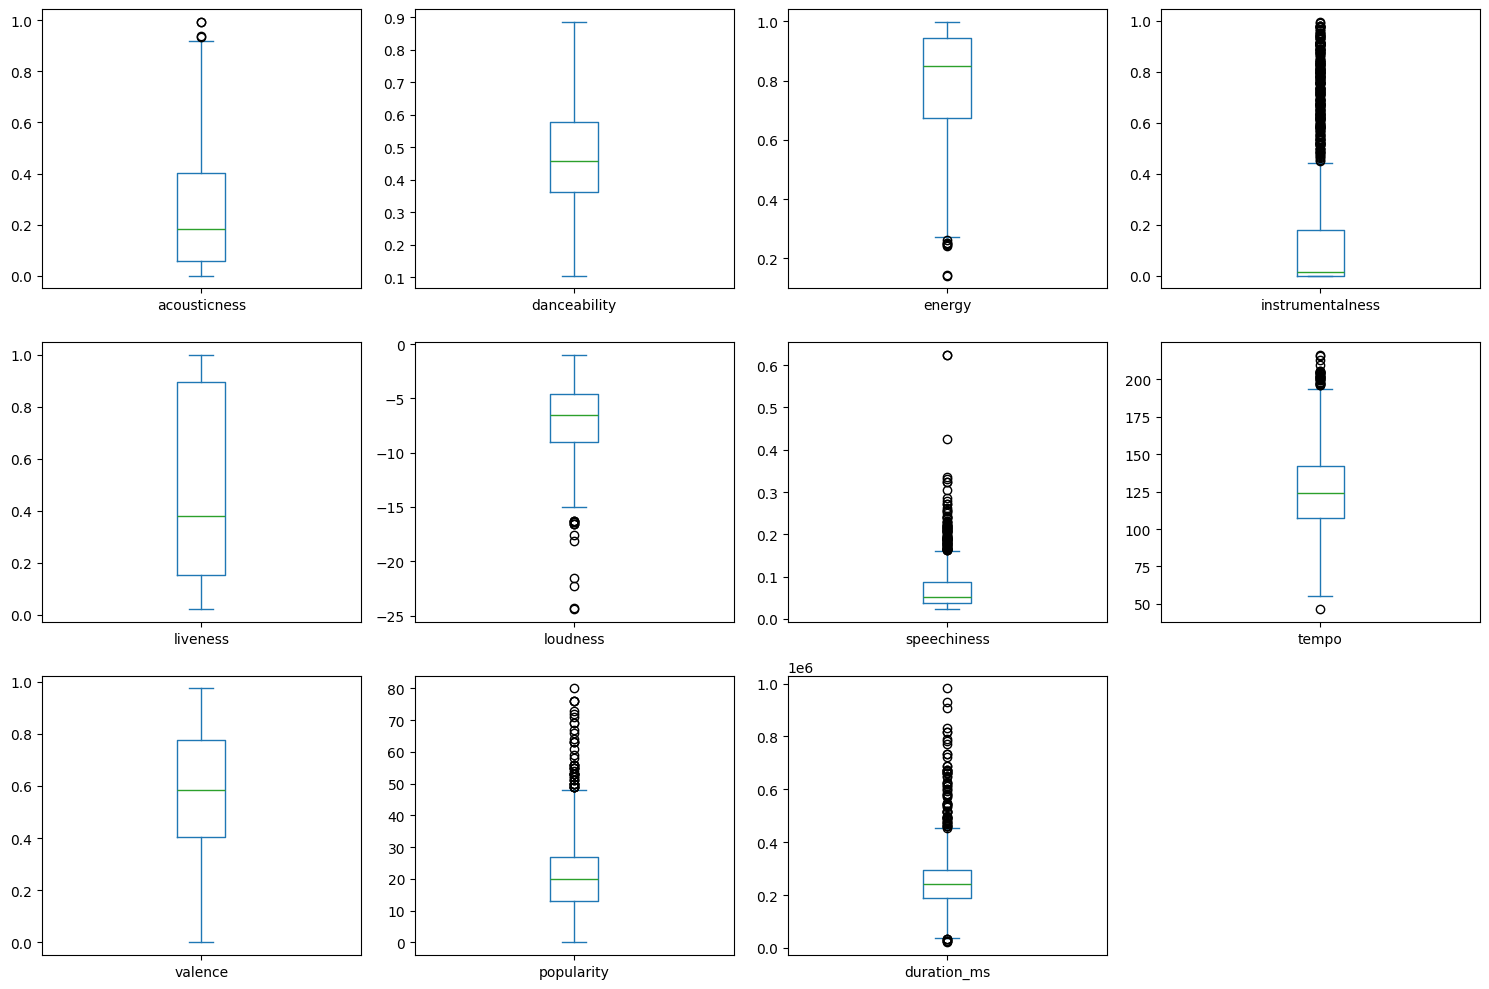

In [36]:
import matplotlib.pyplot as plt
raw_data.select_dtypes(include='number').drop(['track_number'],axis=1).plot(kind='box',subplots=True,figsize=(15,10), layout= (3,4), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

There are outliers. Lets fix them

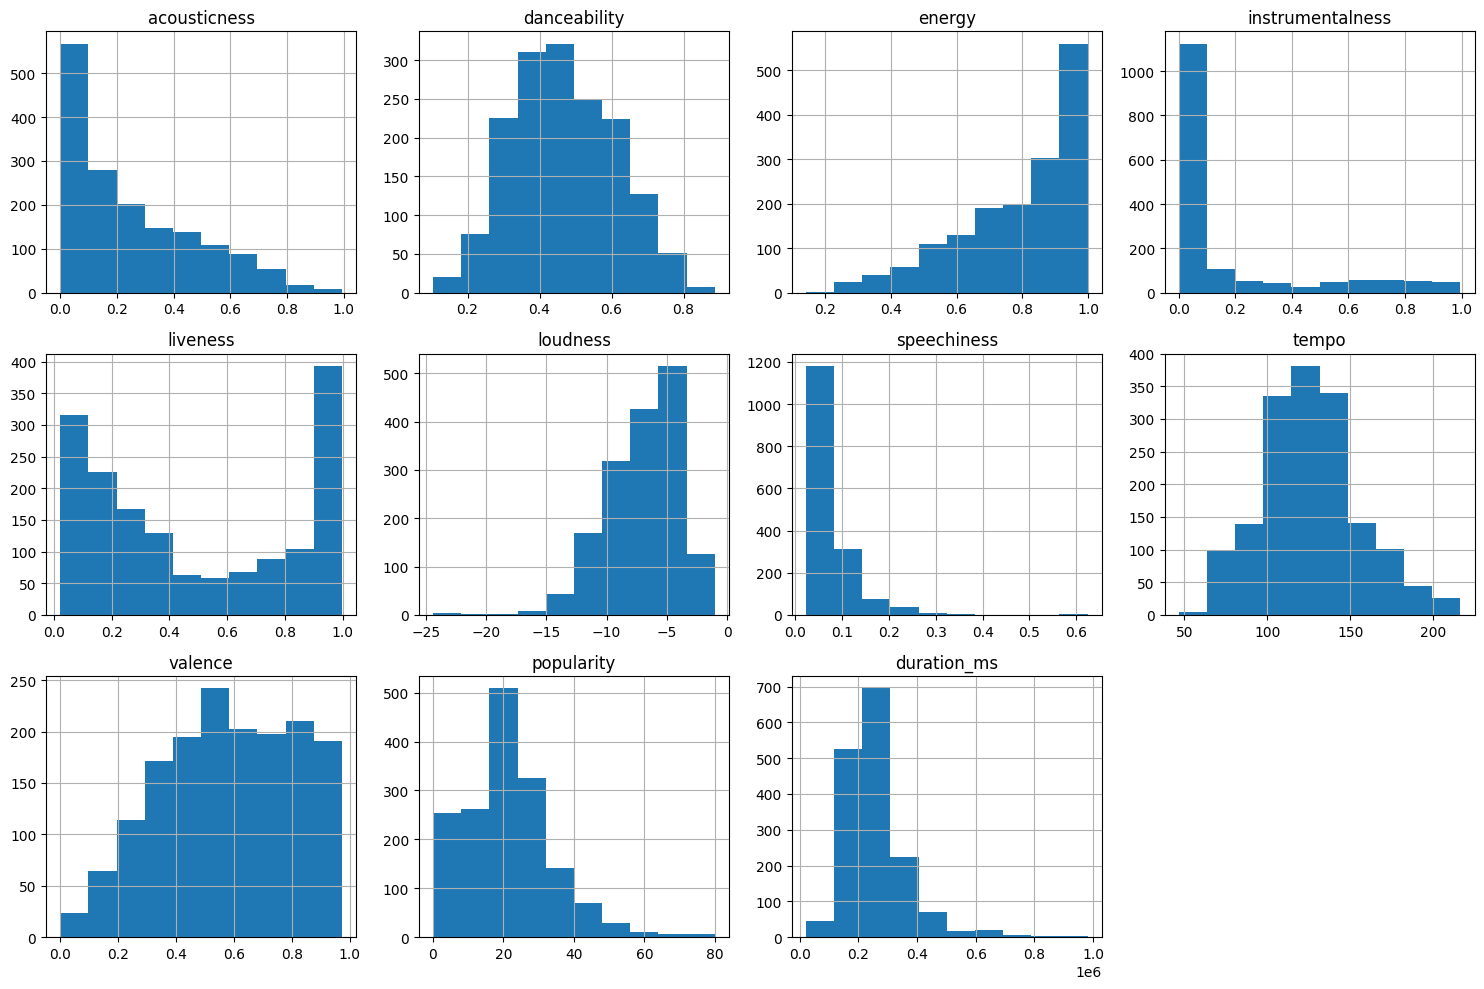

In [37]:
raw_data.select_dtypes(include='number').drop(['track_number'],axis=1).hist(figsize=(15,10), layout= (3,4), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

Distribution is skewed. We will use median to replace outliers

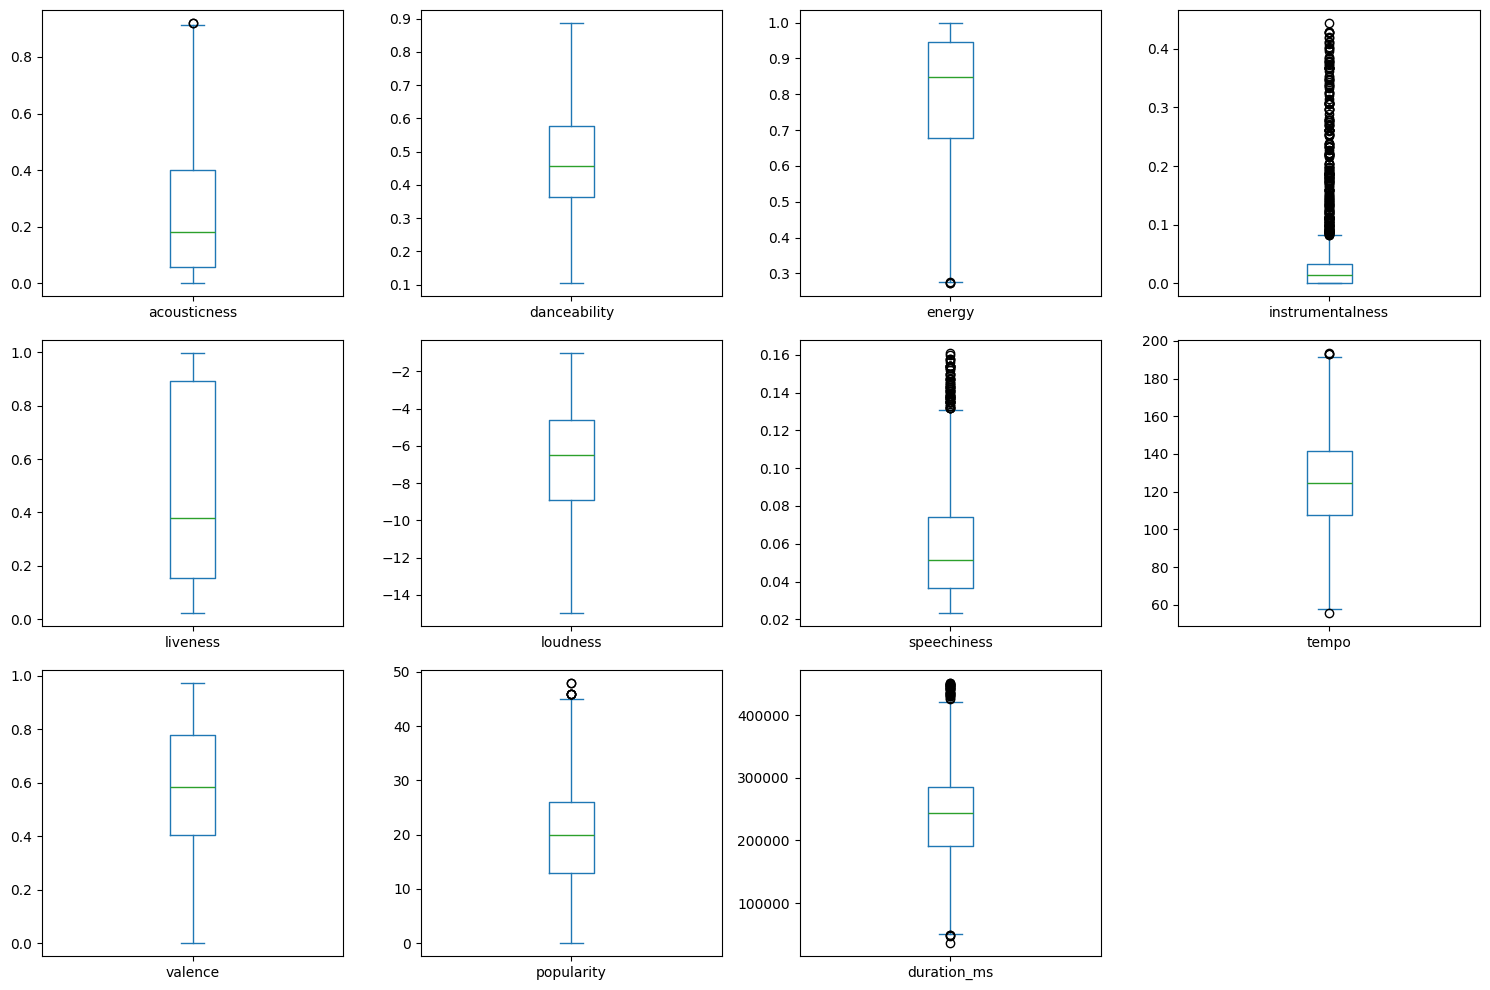

In [38]:
import numpy as np
def detect_outliers_iqr(data):
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    IQR = q3 - q1
    lwr_bound = q1 - (1.5 * IQR)
    upr_bound = q3 + (1.5 * IQR)
    outliers = []
    for i in data:
        if i < lwr_bound or i > upr_bound:
            outliers.append(i)
    return outliers


def remove_outliers(data, outlier_columns):

  for column in outlier_columns:
      array = data[column]
      outliers = detect_outliers_iqr(array)
      value = np.median(array)
      for i in outliers:
          # for every i(outlier) in array , replace it by value else retain the same array element
          array = np.where(array == i, value, array)
          data[column] = np.asarray(array)

  return data
data = remove_outliers(raw_data,raw_data.select_dtypes(include='number').drop(['track_number'],axis=1).columns)
data.select_dtypes(include='number').drop(['track_number'],axis=1).plot(kind='box',subplots=True,figsize=(15,10), layout= (3,4), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

Outliers removed

Get top two albums. We should identify the two albums whose songs have the top two average popularity

Top 2 albums
------------
                                                album  popularity
46  Let It Bleed (50th Anniversary Edition / Remas...   35.111111
13                                    Blue & Lonesome   34.916667


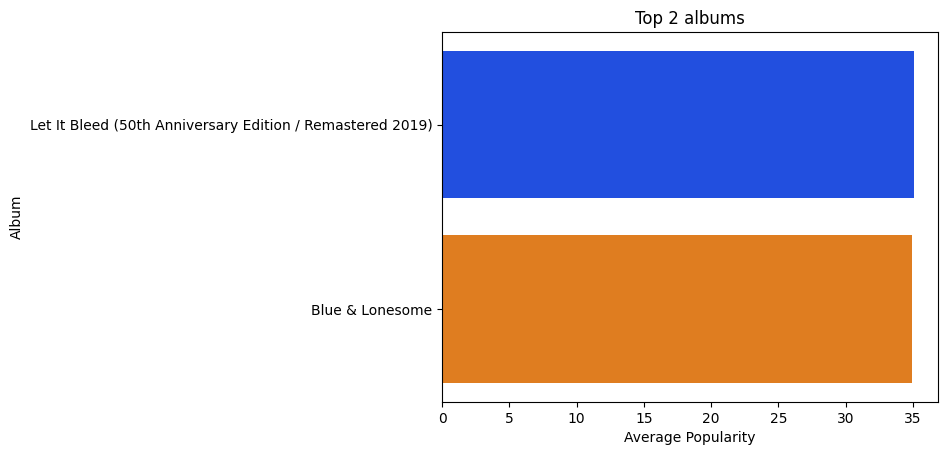

In [39]:
import seaborn as sns

grp_albums = pd.DataFrame(data.groupby('album')['popularity'].mean()).reset_index()
top_2_albums = grp_albums.sort_values(by ='popularity',ascending=False).head(2)
print('Top 2 albums\n------------')
print(top_2_albums)

df = pd.DataFrame(top_2_albums).reset_index()
sns.barplot(data=df,y='album',x='popularity',palette= sns.color_palette("bright"))

plt.xlabel('Average Popularity')
plt.ylabel('Album')
plt.title('Top 2 albums')
plt.show()

Data preprocessing

In [40]:
from sklearn.preprocessing import StandardScaler
#we will exclude track_number from further analysis
numeric_df = data.select_dtypes(include=np.number).drop(['track_number'],axis=1)
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform( numeric_df),columns=numeric_df.columns )
df = data.loc[:,['name','album','track_number']]
# data containing relevant object columns along with scaled numerio columns
songs_data = pd.concat([df,scaled_df],axis=1)
songs_data.head()


name               album  track_number  \
0   Concert Intro Music - Live  Licked Live In NYC             1   
1   Street Fighting Man - Live  Licked Live In NYC             2   
2           Start Me Up - Live  Licked Live In NYC             3   
3  If You Can't Rock Me - Live  Licked Live In NYC             4   
4            Don’t Stop - Live  Licked Live In NYC             5   

   acousticness  danceability    energy  instrumentalness  liveness  loudness  \
0     -0.739913     -0.041343  1.127016         -0.346610  1.261552 -2.178321   
1      0.839405     -1.007963  0.967267          2.299562  1.344648  0.743649   
2      0.745875     -0.584626  0.990089          4.315117  1.330321  0.695730   
3      1.418399     -0.704571  1.081373         -0.511270  1.155532  0.479915   
4      0.674614     -1.170242  0.990089          0.162107  1.358975  0.637363   

   speechiness     tempo   valence  popularity  duration_ms  
0     1.636763 -0.241965 -2.387590    1.278799    -2.640778  
1     0.525524  0.257175 -1.142678    1.374583     0.137324  
2     1.799701  0.205643 -1.164306    1.374583     0.272974  
3    -0.279392  0.314271 -1.882359    1.183016     0.853225  
4     1.082773  0.222969 -1.627147    1.183016     0.842712

EDA

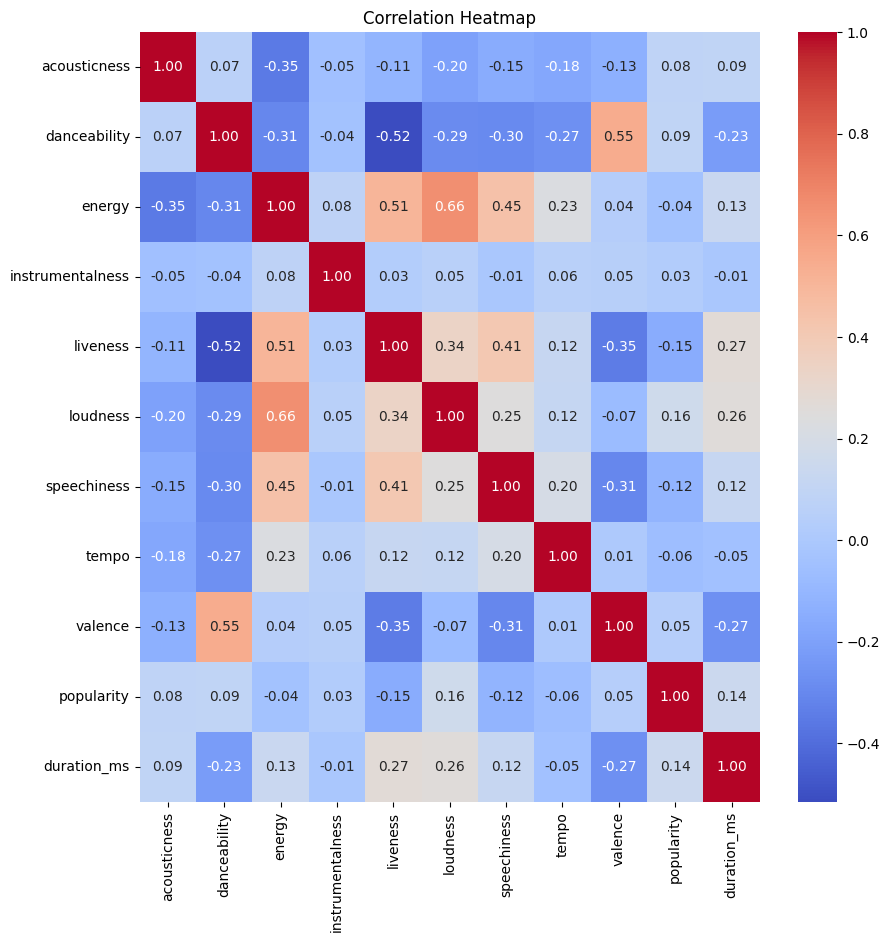

In [41]:
plt.figure(figsize = (10,10))
sns.heatmap(scaled_df.corr(),annot=True,cmap = 'coolwarm',fmt = '0.2f')
plt.title('Correlation Heatmap')
plt.show()



From the heatmap we can see that there are no strong correlations between **popularity** and any one feature of the songs. We however see medium to strong correrlation between features themselves(multicolinear) , such as loudness vs energy, valence vs danceability, liveness vs energy etc. Quite possibly, a combination of these features make a song more or less popular , but what that combination is , is not very obvious.

Lets examine the scatter plots.

<Figure size 1200x1200 with 0 Axes>

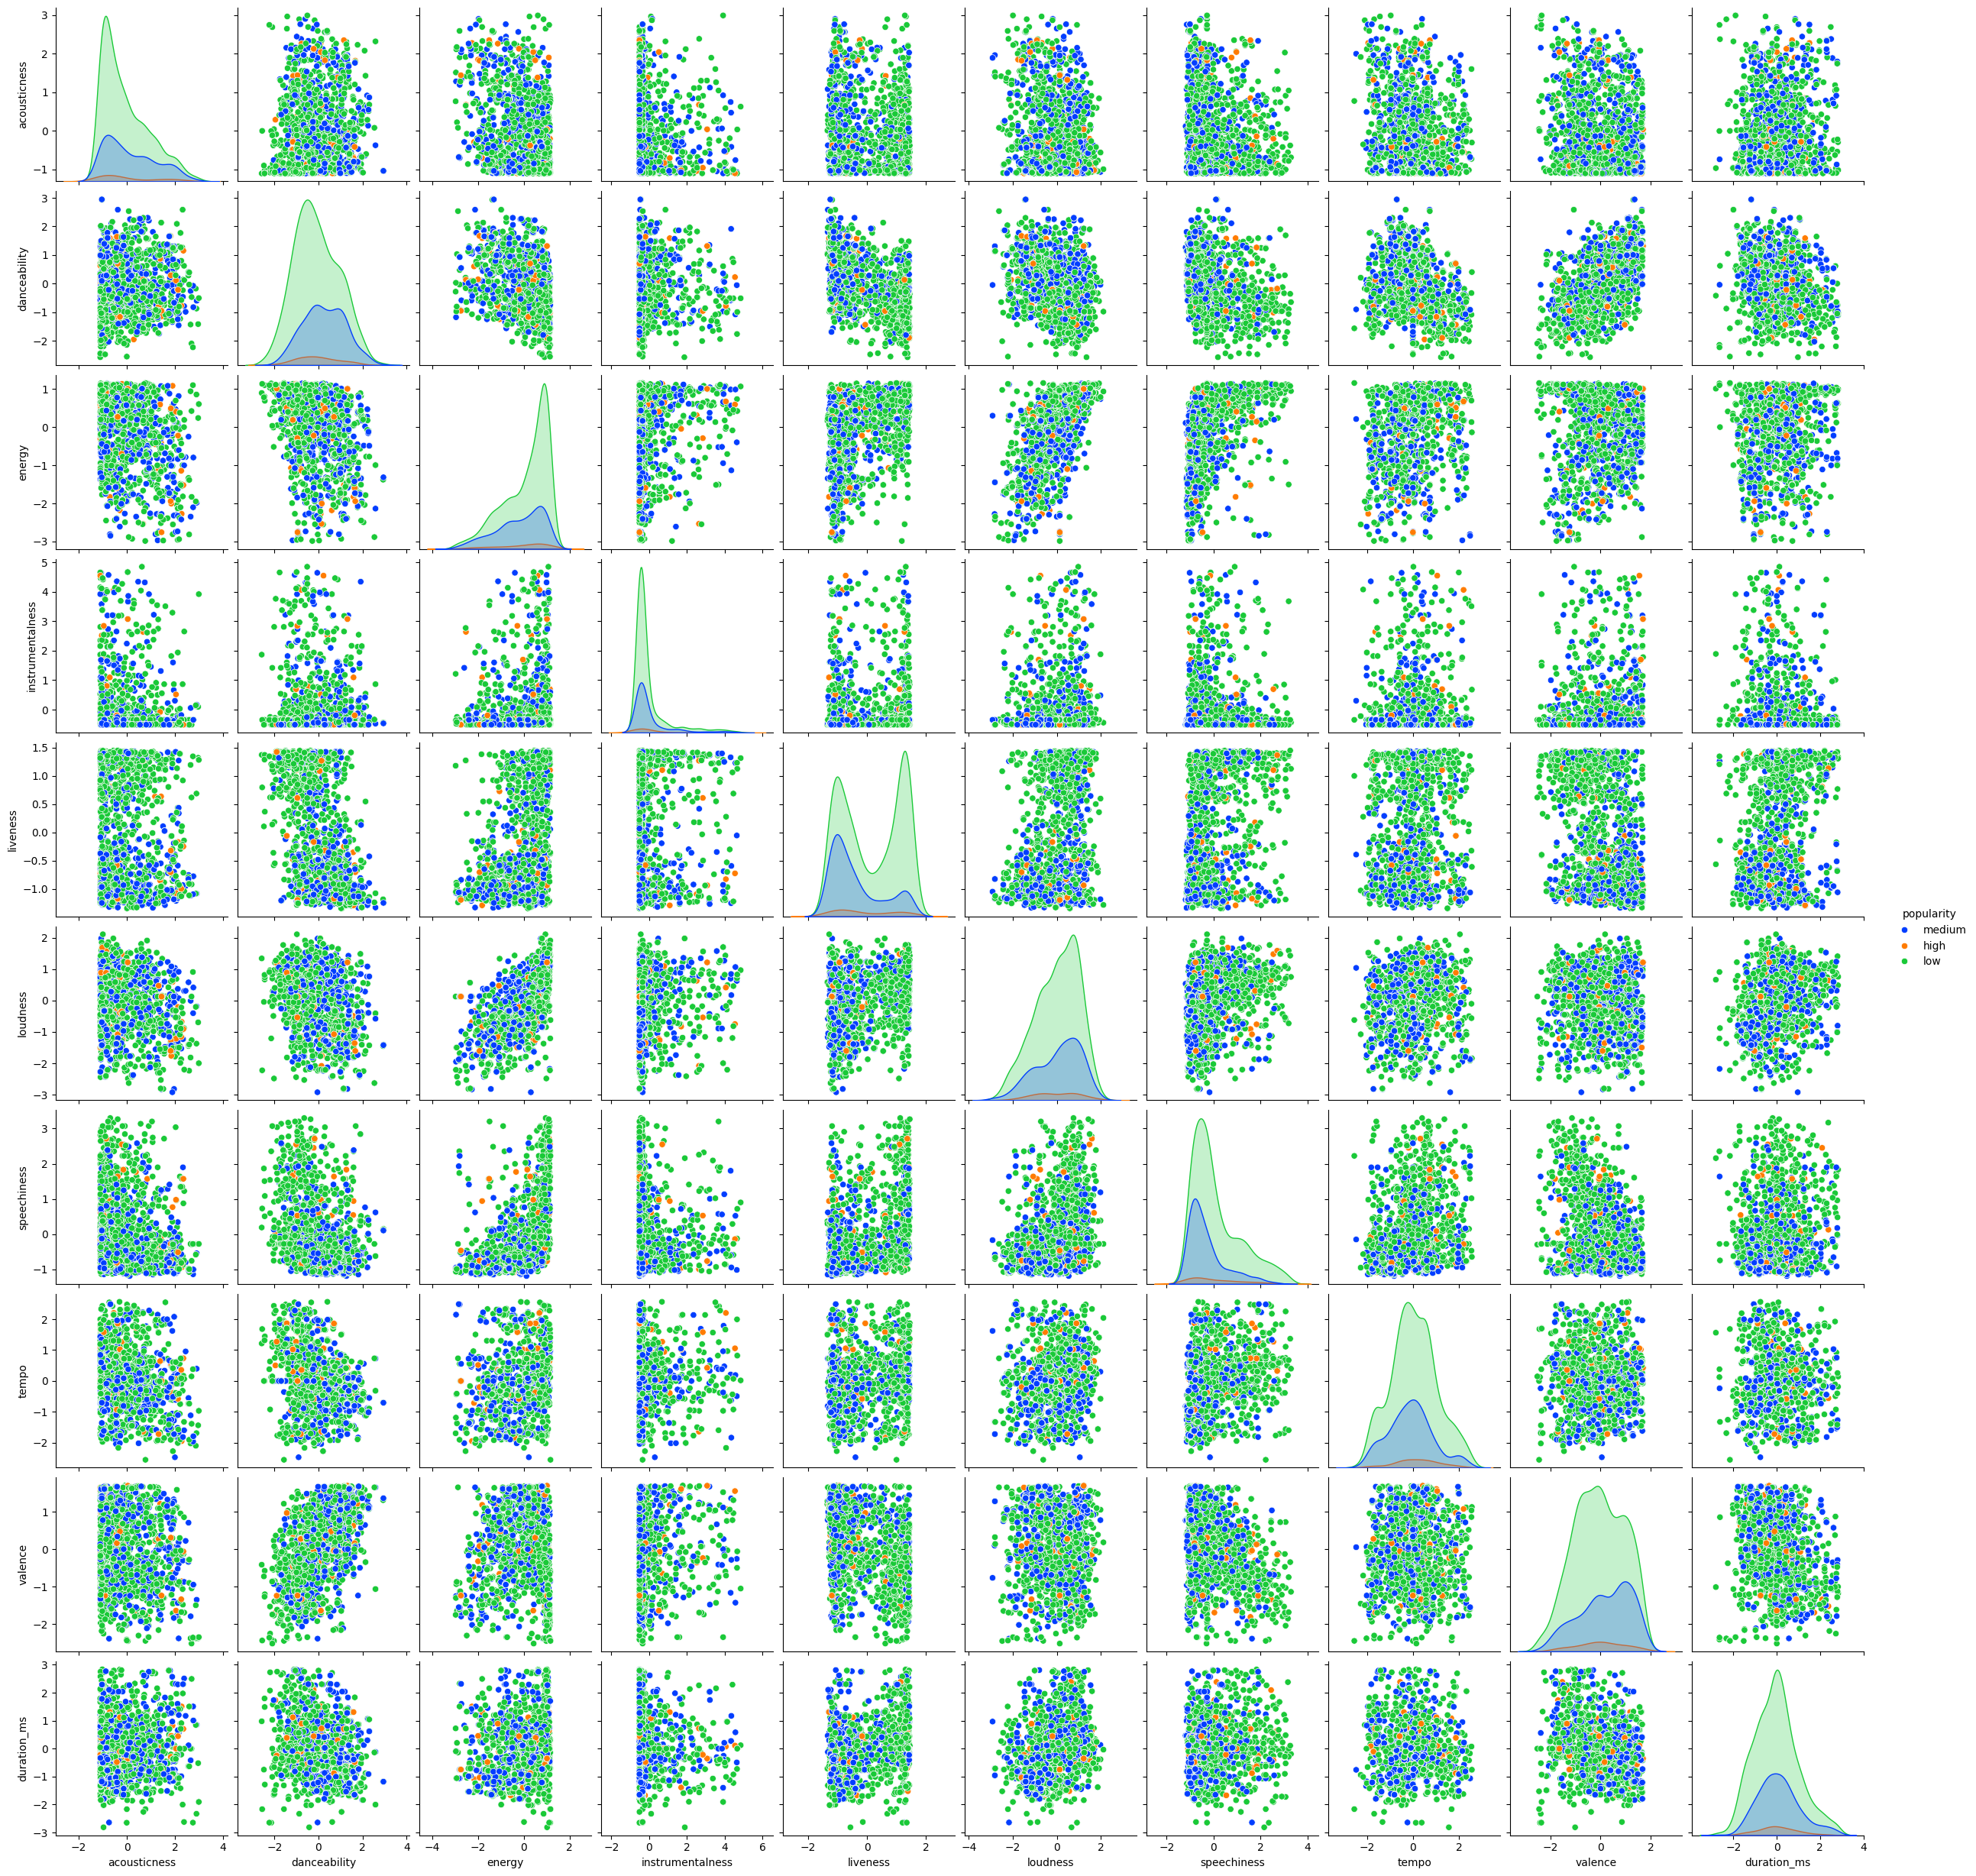

In [42]:
def get(x):
  if 25 < x < 50:
    return 'medium'
  elif x < 25:
    return 'low'
  else:
    return 'high'
plt.figure(figsize=(12,12))
df = scaled_df.loc[:,['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'duration_ms','popularity' ]]
df['popularity'] = data['popularity'].apply(lambda x: get(x))

sns.pairplot(data=df,hue='popularity',palette=sns.color_palette("bright"))
plt.show()


From the above scatter plot, we can see that the there isnt any obvious cluster than we can identify based on individual features. All we can say from the distribution plots is that the dataset has most songs with **low popularity** and only a few highly popular songs.  We cannot get any meaningful insight without sensible feature extraction

We will use Pricipal Component Decomposition to reduce the dimenaionality to better view the clusters

explained variance ratio: 
[0.27250672 0.14511245 0.11930353 0.08865663 0.08496243 0.07028085
 0.06437489 0.06052636 0.04301529 0.03039708 0.02086377]
cumulative explained variance ratio: 
[0.27250672 0.41761917 0.5369227  0.62557933 0.71054176 0.78082261
 0.8451975  0.90572386 0.94873915 0.97913623 1.        ]


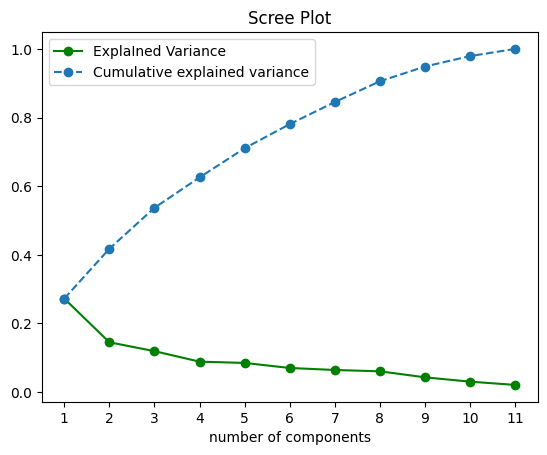

In [11]:
#plot explained variances and their cumulative values
from sklearn.decomposition import PCA

pca = PCA(random_state=123)
pca.fit(scaled_df)
print('explained variance ratio: ')
print(pca.explained_variance_ratio_)
print('cumulative explained variance ratio: ')
print(pca.explained_variance_ratio_.cumsum())
plt.plot(range(1,pca.explained_variance_ratio_.shape[0]+1),pca.explained_variance_ratio_, marker = 'o' , c = 'g', label = 'ExplaIned Variance')
plt.plot(range(1,pca.explained_variance_ratio_.shape[0]+1),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--', label = 'Cumulative explained variance')
plt.legend(loc='best')
plt.xlabel('number of components')
plt.xticks(range(1,pca.explained_variance_ratio_.shape[0]+1))
plt.title('Scree Plot')
plt.show()

We can see that PC1 and PC2 together explain only 42% of the total variance. Clearly we need more components. To explain > 80 % of the variance we need at least 7 components ☹

(1610, 7)


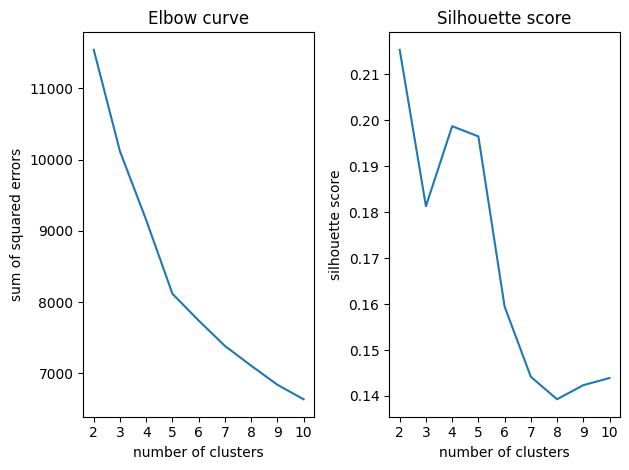

Silhoutte Scores:
 [np.float64(0.21529902895337377), np.float64(0.181283258894155), np.float64(0.19867930532242115), np.float64(0.196462845271958), np.float64(0.15944963904500162), np.float64(0.14417641515536936), np.float64(0.13929077677348448), np.float64(0.1423512326912095), np.float64(0.1439030765534809)]


In [43]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

pca = PCA(n_components=7,random_state=123)
# # we transform the original data agaion with PCA initialized to 7 components
X_pca = pca.fit_transform(scaled_df)
print(X_pca.shape)
sum_squared_errors = []
silhouette_scores = []
max_clusters = 10
for k in range(2,max_clusters+1):
  km = KMeans(n_clusters=k,random_state=123)
  km.fit_transform(X_pca)
  sum_squared_errors.append(km.inertia_)
  labels = km.predict(X_pca)
  silhouette_scores.append(silhouette_score(X_pca,labels))

plt.subplot(1,2,1)
plt.plot(range(2,max_clusters+1),sum_squared_errors)
plt.xticks(range(2,max_clusters+1))
plt.xlabel('number of clusters')
plt.ylabel('sum of squared errors')
plt.title('Elbow curve')

plt.subplot(1,2,2)
plt.plot(range(2,max_clusters+1),silhouette_scores)
plt.xticks(range(2,max_clusters+1))
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.title('Silhouette score')

plt.tight_layout()
plt.show()

print('Silhoutte Scores:\n',silhouette_scores)

There are elbows at clusters 2 , 5 and 7. The silhoutte scorees indicate that cluster 2 has the best score!!! We will plot the scatteer plot for clusters 2,3,4 and 5 to confirm

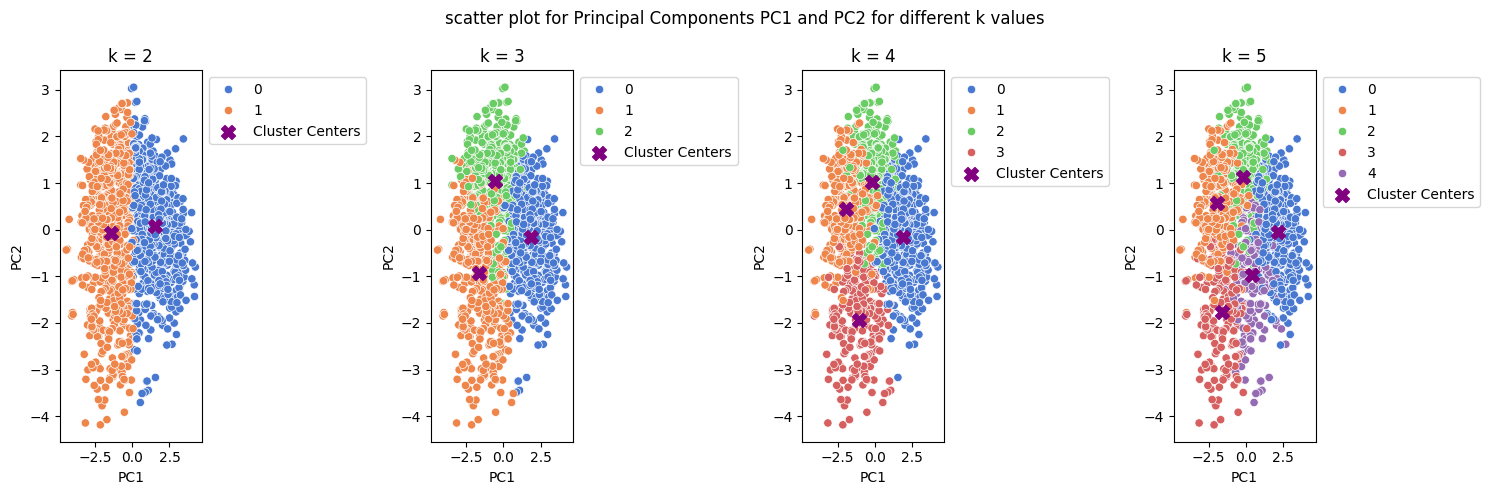

In [44]:
_,axes = plt.subplots(nrows=1,ncols=4,figsize=(15,5),layout='tight')
for i,k in enumerate([2,3,4,5]):
  kmeans_pca = KMeans(n_clusters=k,random_state = 42)
  kmeans_pca.fit(X_pca)
  column_names = ['PC'+str(i+1) for i in range(X_pca.shape[1])]
  scores_df = pd.DataFrame(X_pca,columns=column_names)
  scores_df['cluster'] = kmeans_pca.predict(X_pca)
  axe = sns.scatterplot(
      x='PC1',
      y='PC2',
      data=scores_df,
      hue='cluster',
      ax = axes[i],
      palette=sns.color_palette("muted")
      )
  cluster_centers = kmeans_pca.cluster_centers_
  axe.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='X',s=100,c='purple', label = 'Cluster Centers')
  axe.legend(loc='upper left', bbox_to_anchor=(1, 1))
  axe.set_title(f'k = {k}')
plt.suptitle('scatter plot for Principal Components PC1 and PC2 for different k values')
plt.show()

With 2 clusters we have clear boundaries with 2 dense clusters, although 3 clusters also looks good. But we will trust the silhoutte score

In [45]:
# In order to create a cohort of songs, we will need to relate the scatter plot to the original variables.
#Loading = Eigenvector * sqrt(Eigenvalue)
eigen_vectors = pca.components_.T # Eigen Vector :is the transpose of pca.components_
print('Eigen Vectors\n',pd.DataFrame(eigen_vectors))
eigen_values = pca.explained_variance_ # Eigen Value : is the pca.explained_variance_ for each component
print('\neigen values\n',pd.DataFrame(eigen_values))
loadings  = eigen_vectors * np.sqrt(eigen_values)
loadings_df = pd.DataFrame(loadings,columns=['PC1', 'PC2','PC3','PC4','PC5','PC6', 'PC7'],
                         index=scaled_df.columns )

print('\nLoadings Dataframe:\n')
loadings_df




Eigen Vectors
            0         1         2         3         4         5         6
0  -0.167668 -0.487544  0.127977  0.101484  0.016343  0.706816  0.354548
1  -0.406390  0.263384  0.152871 -0.203167 -0.185918  0.263083  0.020233
2   0.429858  0.366880  0.133196 -0.133616 -0.126460  0.174960  0.087936
3   0.041005  0.156033  0.075599  0.879409 -0.411620  0.068726 -0.087841
4   0.438562 -0.115083 -0.077529 -0.047678 -0.238219  0.023673  0.116326
5   0.371294  0.218969  0.416594 -0.098636 -0.015773  0.046121  0.098364
6   0.368969  0.000906 -0.180705 -0.155385 -0.029491  0.536496 -0.403316
7   0.194357  0.228527 -0.281524  0.312946  0.720231  0.105350  0.340582
8  -0.258919  0.562877  0.127047 -0.080277 -0.064006  0.152444  0.366286
9  -0.053179 -0.011382  0.667175  0.127740  0.441761  0.062663 -0.459190
10  0.215174 -0.321879  0.429024 -0.019166 -0.062403 -0.259007  0.459945

eigen values
           0
0  3.058512
1  1.611445
2  1.310752
3  1.006264
4  0.907673
5  0.719292
6  0.71561

PC1       PC2       PC3       PC4       PC5       PC6  \
acousticness     -0.293227 -0.618901  0.146518  0.101802  0.015570  0.599458   
danceability     -0.710719  0.334346  0.175019 -0.203802 -0.177127  0.223124   
energy            0.751761  0.465727  0.152494 -0.134034 -0.120481  0.148386   
instrumentalness  0.071712  0.198073  0.086552  0.882159 -0.392158  0.058287   
liveness          0.766984 -0.146089 -0.088761 -0.047827 -0.226955  0.020077   
loudness          0.649341  0.277965  0.476951 -0.098945 -0.015027  0.039116   
speechiness       0.645276  0.001150 -0.206886 -0.155871 -0.028097  0.455008   
tempo             0.339904  0.290099 -0.322312  0.313925  0.686178  0.089348   
valence          -0.452813  0.714531  0.145453 -0.080529 -0.060980  0.129289   
popularity       -0.093002 -0.014449  0.763835  0.128140  0.420874  0.053145   
duration_ms       0.376309 -0.408602  0.491181 -0.019226 -0.059453 -0.219667   

                       PC7  
acousticness      0.299926  
danceability      0.017116  
energy            0.074389  
instrumentalness -0.074308  
liveness          0.098405  
loudness          0.083210  
speechiness      -0.341181  
tempo             0.288112  
valence           0.309856  
popularity       -0.388447  
duration_ms       0.389085

Scatter plot to examine the influence of features on the Principal Components


Feature Loading on PC1
 liveness            0.766984
energy              0.751761
loudness            0.649341
speechiness         0.645276
duration_ms         0.376309
tempo               0.339904
instrumentalness    0.071712
popularity         -0.093002
acousticness       -0.293227
valence            -0.452813
danceability       -0.710719
Name: PC1, dtype: float64

Feature Loading on PC2
 valence             0.714531
energy              0.465727
danceability        0.334346
tempo               0.290099
loudness            0.277965
instrumentalness    0.198073
speechiness         0.001150
popularity         -0.014449
liveness           -0.146089
duration_ms        -0.408602
acousticness       -0.618901
Name: PC2, dtype: float64


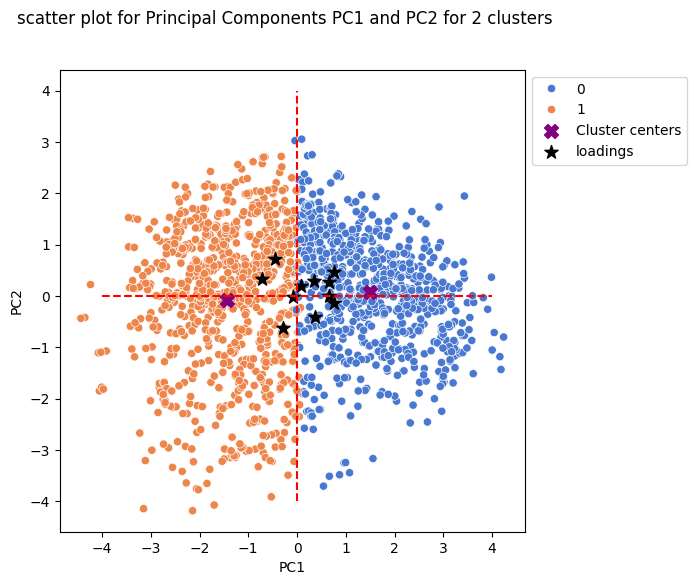

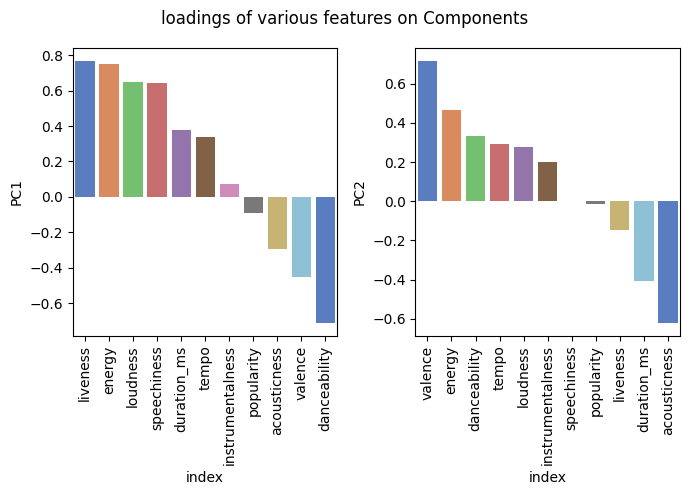


Feature Loading on PC3
 popularity          0.763835
duration_ms         0.491181
loudness            0.476951
danceability        0.175019
energy              0.152494
acousticness        0.146518
valence             0.145453
instrumentalness    0.086552
liveness           -0.088761
speechiness        -0.206886
tempo              -0.322312
Name: PC3, dtype: float64


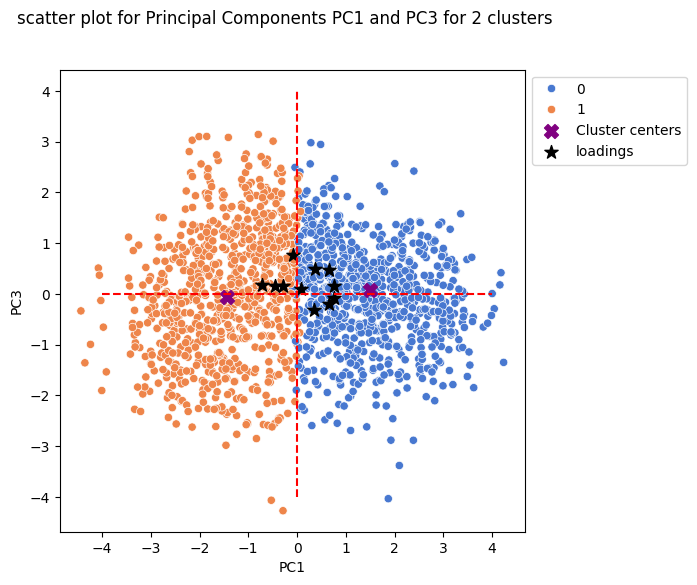

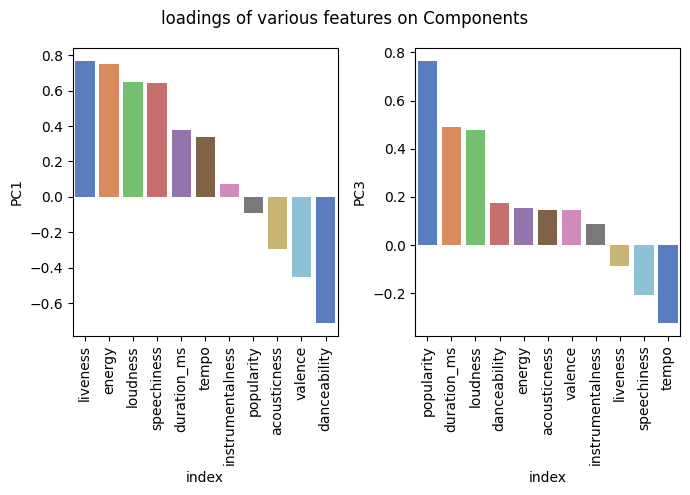


Feature Loading on PC4
 instrumentalness    0.882159
tempo               0.313925
popularity          0.128140
acousticness        0.101802
duration_ms        -0.019226
liveness           -0.047827
valence            -0.080529
loudness           -0.098945
energy             -0.134034
speechiness        -0.155871
danceability       -0.203802
Name: PC4, dtype: float64


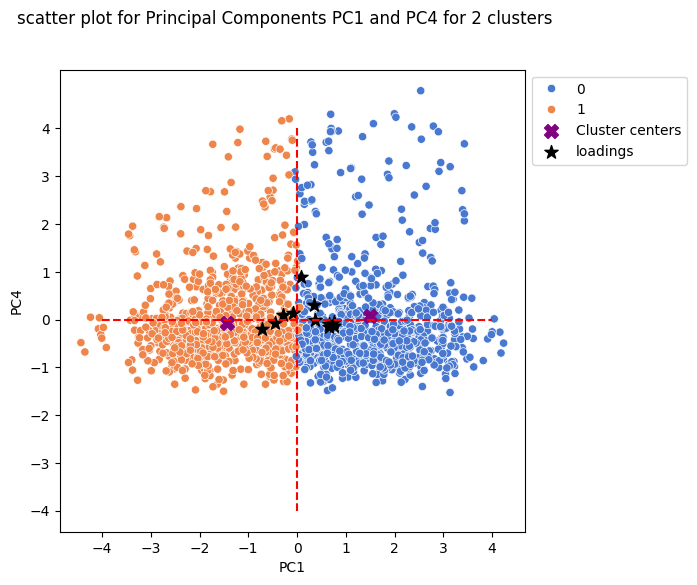

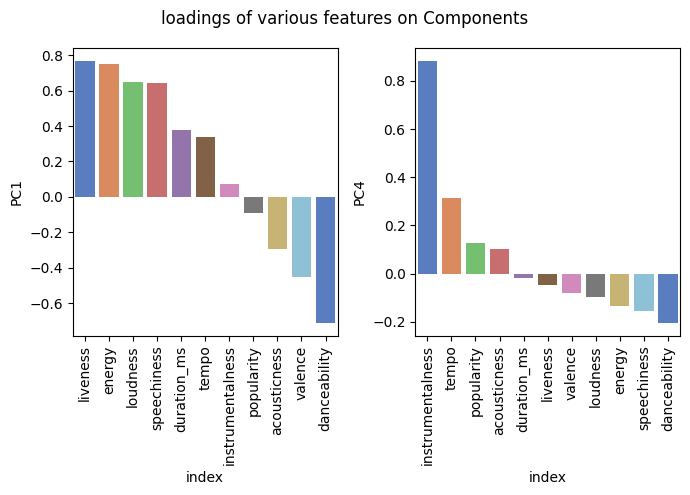


Feature Loading on PC5
 tempo               0.686178
popularity          0.420874
acousticness        0.015570
loudness           -0.015027
speechiness        -0.028097
duration_ms        -0.059453
valence            -0.060980
energy             -0.120481
danceability       -0.177127
liveness           -0.226955
instrumentalness   -0.392158
Name: PC5, dtype: float64


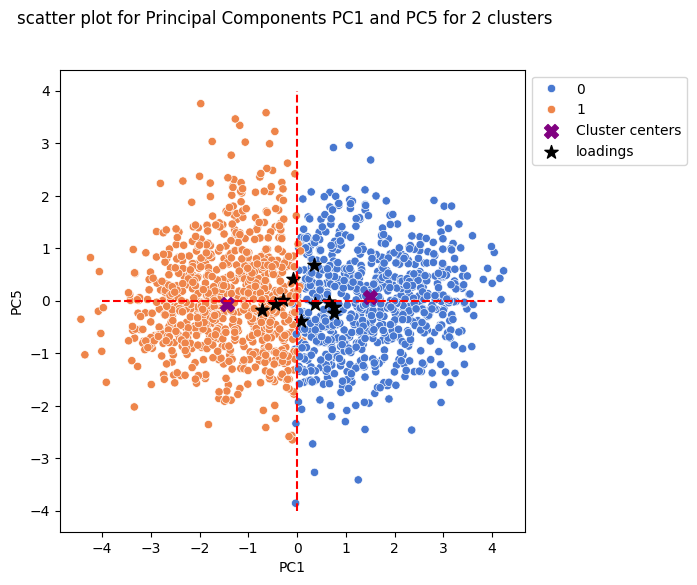

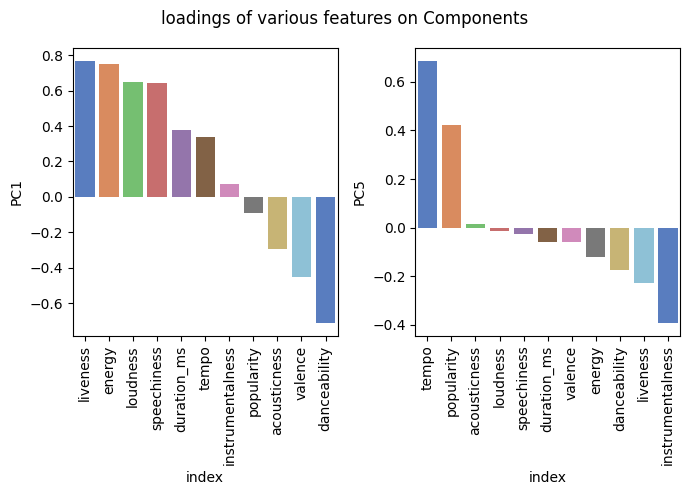


Feature Loading on PC6
 acousticness        0.599458
speechiness         0.455008
danceability        0.223124
energy              0.148386
valence             0.129289
tempo               0.089348
instrumentalness    0.058287
popularity          0.053145
loudness            0.039116
liveness            0.020077
duration_ms        -0.219667
Name: PC6, dtype: float64


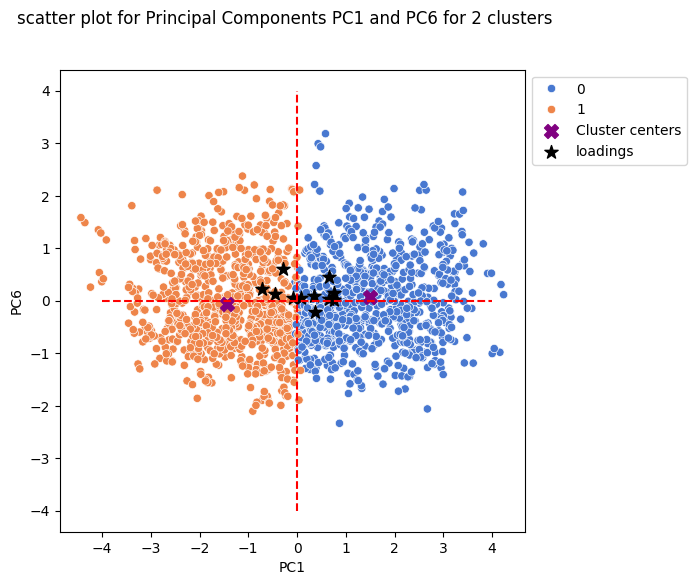

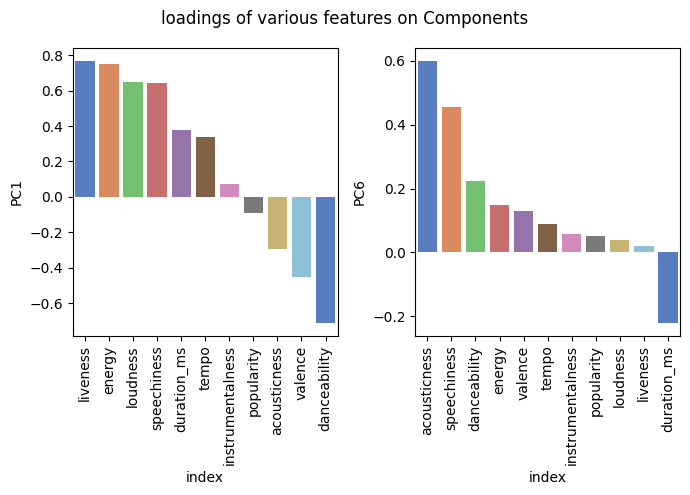


Feature Loading on PC7
 duration_ms         0.389085
valence             0.309856
acousticness        0.299926
tempo               0.288112
liveness            0.098405
loudness            0.083210
energy              0.074389
danceability        0.017116
instrumentalness   -0.074308
speechiness        -0.341181
popularity         -0.388447
Name: PC7, dtype: float64


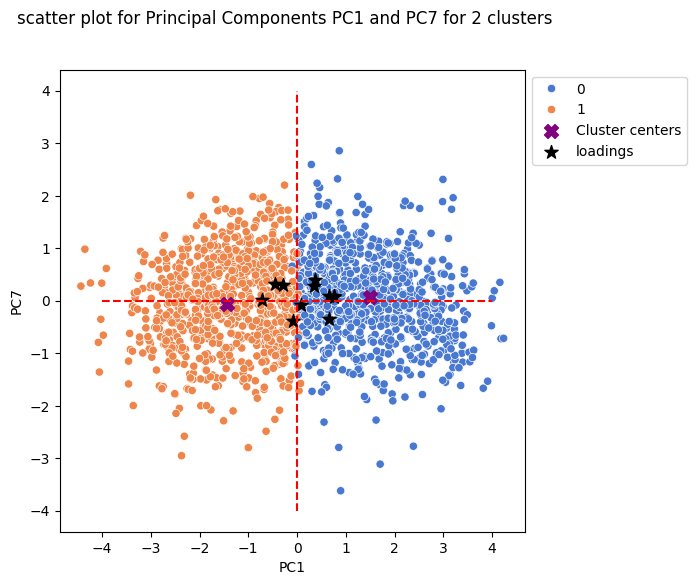

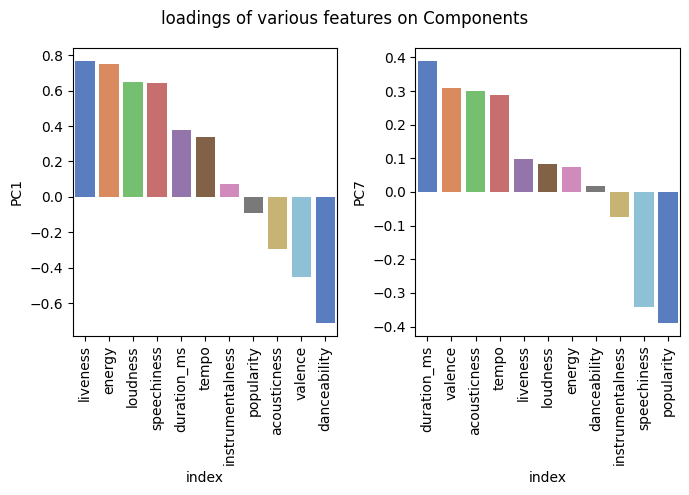

In [46]:
def do_cluster_analysis(comp1,comp2,loadings):
  kmeans_pca = KMeans(n_clusters=2
                      ,random_state = 42)
  kmeans_pca.fit(X_pca)
  column_names = ['PC'+str(i+1) for i in range(X_pca.shape[1])]
  scores_df = pd.DataFrame(X_pca,columns=column_names)
  scores_df['cluster'] = kmeans_pca.predict(X_pca)
  plt.figure(figsize=(6,6))
  axe = sns.scatterplot(
      x=comp1,
      y=comp2,
      data=scores_df,
      hue='cluster',
      palette=sns.color_palette("muted")
      )
  cluster_centers = kmeans_pca.cluster_centers_
  axe.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='X',s=100,c='purple', label = 'Cluster centers')
  axe.scatter(loadings[comp1],loadings[comp2],marker='*',s=100,c='black',label='loadings')


  axe.legend(loc='upper left', bbox_to_anchor=(1, 1))
  axe.plot([-4,0,4],[0,0,0], linestyle='--',color='red')
  axe.plot([0,0,0],[-4,0,4], linestyle='--',color='red')
  plt.xticks(np.arange(-4, 5, 1))
  plt.yticks(np.arange(-4, 5, 1))
  plt.suptitle(f'scatter plot for Principal Components {comp1} and {comp2} for 2 clusters')

  fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(7,5),layout='tight')
  for i,comp in enumerate(loadings.columns):
    comp_loading = pd.DataFrame(loadings.sort_values(by=comp,ascending=False)[[comp]]).reset_index()
    bars = sns.barplot(data = comp_loading,x='index',y=comp,ax=ax[i],palette=sns.color_palette("muted"))
    xticks = bars.get_xticklabels()
    bars.set_xticks(bars.get_xticks())
    bars.set_xticklabels(xticks, rotation=90)
  plt.suptitle('loadings of various features on Components')
  plt.tight_layout()
  plt.show()

#['PC3','PC4'],['PC5','PC6'] do not produce any identifyable clusters.
#Only groups that has PC1 produce meaningful clusters
comp_grps = [['PC1','PC2'],['PC1','PC3'],['PC1','PC4'],['PC1','PC5'],['PC1','PC6'],['PC1','PC7']]

print(f'\nFeature Loading on PC1\n',loadings_df.sort_values(by='PC1',ascending=False)['PC1'])
for comp in comp_grps:
  loadings = loadings_df.loc[:,[comp[0],comp[1]]]
  print(f'\nFeature Loading on {comp[1]}\n',loadings.sort_values(by=comp[1],ascending=False)[comp[1]])
  do_cluster_analysis(comp[0],comp[1],loadings)

 We can see the clusters(Cohorts) having the following characteristics. In defining  characteristics, We will pick the feature that has the maximum influence on a component

**cohort_1(PC1)**<br>
* liveness :       0.770252

From the dictionary, the above loadings indiacate that this cohort will consist of live performance songs

**cohort_2<br>**
* valence    :         0.715215

From the dictionary, the above loadings indicate that this cohort will consist of cheerful , positve and happy songs

**cohort_3(PC3)**<p>
* popularity :         0.764004


This cohort will contain popular songs

**cohort_4**<br>
* instrumentalness :   0.876044

This cohort will mainly consist of instrumentals with minimum spoken content(speechiness = -0.151596)

**cohort_5(PC5)**<br>
*  tempo       :        0.704969

This cohort will contain fast paced , racy songs

**cohort_6(PC6)**<br>
* speechiness     :    0.528427
 This cohort will contain songs that has spoken content(vocals , rap etc)

**Cohort_7**<br>
*   acousticness :        0.43239
*   valence    :          0.350231

This is ignored








**Cohorts of songs**




  

In [47]:
# combine the original songs data with scores data
combined_df = pd.concat([songs_data,scores_df],axis=1)
combined_df.head()

name               album  track_number  \
0   Concert Intro Music - Live  Licked Live In NYC             1   
1   Street Fighting Man - Live  Licked Live In NYC             2   
2           Start Me Up - Live  Licked Live In NYC             3   
3  If You Can't Rock Me - Live  Licked Live In NYC             4   
4            Don’t Stop - Live  Licked Live In NYC             5   

   acousticness  danceability    energy  instrumentalness  liveness  loudness  \
0     -0.739913     -0.041343  1.127016         -0.346610  1.261552 -2.178321   
1      0.839405     -1.007963  0.967267          2.299562  1.344648  0.743649   
2      0.745875     -0.584626  0.990089          4.315117  1.330321  0.695730   
3      1.418399     -0.704571  1.081373         -0.511270  1.155532  0.479915   
4      0.674614     -1.170242  0.990089          0.162107  1.358975  0.637363   

   speechiness  ...  popularity  duration_ms       PC1       PC2       PC3  \
0     1.636763  ...    1.278799    -2.640778  0.894424 -0.475196 -1.793145   
1     0.525524  ...    1.374583     0.137324  2.140986 -0.596746  1.125031   
2     1.799701  ...    1.374583     0.272974  2.547915 -0.192083  1.154046   
3    -0.279392  ...    1.183016     0.853225  1.743398 -1.864110  1.167737   
4     1.082773  ...    1.183016     0.842712  2.609915 -1.414086  0.897397   

        PC4       PC5       PC6       PC7  cluster  
0 -0.291789  0.389573  0.821667 -3.620043        0  
1  2.309035 -0.358267  0.906937 -0.721101        0  
2  3.773415 -1.348635  1.731897 -1.404096        0  
3  0.018197  0.769469  0.470137  0.189706        0  
4  0.355945  0.405701  0.627099 -0.603282        0  

[5 rows x 22 columns]

In [48]:
# features influencing principal components are listed in order (pc1 t pc6)
cohorts = []
cohort_features = ['liveness', 'valence', 'popularity', 'instrumentalness', 'tempo', 'speechiness']
for index,feature in enumerate(cohort_features):
  cohort = combined_df.sort_values(by=feature,ascending=False).head(100).loc[:,['name','album','track_number']]
  cohorts.append(cohort)
  cohort.to_csv(f'cohort{index+1}.csv')

print('{} cohorts of songs created '.format(index+1))

6 cohorts of songs created 


In [55]:
pd.read_csv('cohort1.csv',index_col = 1).drop('Unnamed: 0',axis=1).head()

album  \
name                                                                    
Shattered - Live / Remastered 2009                         Still Life   
You Can't Always Get What You Want - Live At Tw...         Live Licks   
Just My Imagination (Running Away With Me) - Li...         Still Life   
Brown Sugar - Live                                  Steel Wheels Live   
You Can't Always Get What You Want - Live Licks...         Live Licks   

                                                    track_number  
name                                                              
Shattered - Live / Remastered 2009                             4  
You Can't Always Get What You Want - Live At Tw...             4  
Just My Imagination (Running Away With Me) - Li...             9  
Brown Sugar - Live                                            25  
You Can't Always Get What You Want - Live Licks...             4

In [56]:
pd.read_csv('cohort2.csv',index_col = 1).drop('Unnamed: 0',axis=1).head()

album  track_number
name                                                                      
Bitch - 2009 Mix                               Honk (Deluxe)            25
Bitch - 2009 Mix               Sticky Fingers (Super Deluxe)             6
Bitch - 2009 Mix                 Sticky Fingers (Remastered)             6
Bitch - 2009 Mix                     Sticky Fingers (Deluxe)             6
Start Me Up - Remastered 2009  Tattoo You (2009 Re-Mastered)             1

In [57]:
pd.read_csv('cohort3.csv',index_col = 1).drop('Unnamed: 0',axis=1).head()

album  track_number
name                                                                 
Anybody Seen My Baby?                Bridges To Babylon             2
Midnight Rambler                           Let It Bleed             6
Out Of Time                      Aftermath (UK Version)             9
Miss You - Remastered       Some Girls (Deluxe Version)             1
Far Away Eyes - Remastered                   Some Girls             6

In [58]:
pd.read_csv('cohort4.csv',index_col = 1).drop('Unnamed: 0',axis=1).head()

album  \
name                                                                                                  
Honky Tonk Women - Live                                                        A Bigger Bang (Live)   
Midnight Rambler - Live At The Roundhouse / 1971                      Sticky Fingers (Super Deluxe)   
Midnight Rambler - Live At The Roundhouse / 1971                            Sticky Fingers (Deluxe)   
The Last Time - Live                              Live 1965: Music From Charlie Is My Darling (L...   
Doo Doo Doo Doo Doo (Heartbreaker) - 2020                                  Goats Head Soup (Deluxe)   

                                                  track_number  
name                                                            
Honky Tonk Women - Live                                     17  
Midnight Rambler - Live At The Roundhouse / 1971             9  
Midnight Rambler - Live At The Roundhouse / 1971             9  
The Last Time - Live                                        12  
Doo Doo Doo Doo Doo (Heartbreaker) - 2020                    4

In [59]:
pd.read_csv('cohort5.csv',index_col = 1).drop('Unnamed: 0',axis=1).head()

album  track_number
name                                                                        
Break The Spell                                   Steel Wheels            11
Around And Around - Live            Love You Live (Remastered)             4
Break The Spell - Remastered    Steel Wheels (Remastered 2009)            11
She Smiled Sweetly            Between The Buttons (UK Version)             5
She Smiled Sweetly                         Between The Buttons             5